# MLP on MINST Dataset

In [1]:
Pkg.update()
Pkg.add("MNIST")
using PyPlot

INFO: Updating METADATA...
INFO: Computing changes...
INFO: No packages to install, update or remove
INFO: Nothing to be done


In [2]:
using MNIST
function mnistData()
    features = trainfeatures(1)
    label = trainlabel(1)

    trainX, trainY = traindata()
    N = size(trainX)[2]
    idx = randperm(N)
    trainX = trainX[:, idx]'
    trainY = trainY[idx]

    testX, testY = testdata()
    N = size(testX)[1]
    idx = randperm(N)
    testX = testX[:, idx]'
    testY = testY[idx]

    ttl = 55000
    trX, trY = trainX[1:ttl,:], trainY[1:ttl,:]

    @assert size(trX)[1] == size(trY)[1]
    println(size(trX), size(trY))

    trX = trX / 256. 
    return trX, trY
end
trainX, trainY = mnistData()


(55000,784)(55000,1)


(
[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],

[6.0; 1.0; … ; 4.0; 7.0])

In [11]:
include("layers/SoftMaxCrossEntropy.jl")
include("layers/SquareLossLayer.jl")
include("layers/FCLayer.jl")
include("layers/DropoutLayer.jl")
include("layers/ReLu.jl")
include("layers/Tanh.jl")
include("layers/SequnetialNet.jl")

([2.40761,1.31818],[2,1])
[0.244728 -0.909969 0.665241; 0.00490169 0.727475 -0.732377]
Diff: [0.0; 0.0; 2.0; 5.0]
(
[14.5],

[-1; 1; 1; 1])
dldy:[0.0; 0.0; 2.0; 5.0]


[0.0; 0.0; 2.0; 5.0]
FCLayer(2,[-2.09181 -1.37634 -1.48249; -4.93522 0.885333 -7.0661; 0.0 0.0 0.0],[0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,0.0],[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0])
[3.0 22.0 21.0; 7.0 46.0 45.0]


[56.0 110.0; 74.0 144.0]
[26.0 30.0 34.0; 38.0 44.0 50.0; 12.0 14.0 16.0]
[1.0 2.0; 0.0 3.0; 1.0 0.0; 0.0 0.0]


[2.0 3.0; 0.0 5.0; 3.0 0.0; 0.0 0.0]
[0.761594 0.964028; -0.761594 0.995055; 0.761594 -0.964028; -0.995055 -0.995055]
[0.839949 0.211952; 0.839949 0.0493302; 1.25992 0.423905; 0.0197321 0.0197321]


backward (generic function with 7 methods)

In [4]:
size(trainX), size(trainY)
i = convert(Int, ceil(rand() * size(trainX)[1]))

47422

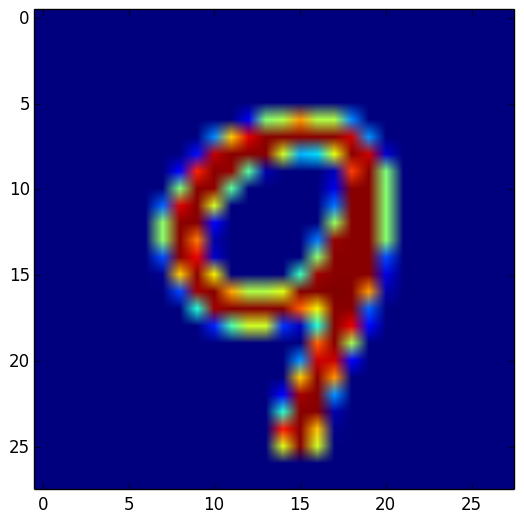

PyObject <matplotlib.image.AxesImage object at 0x320b4ea50>

  likely near /Users/jennyw/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/jennyw/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/jennyw/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/jennyw/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/jennyw/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/jennyw/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/jennyw/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/jennyw/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/jennyw/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/jennyw/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/jennyw/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/jennyw/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/jennyw/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/jennyw/.julia/v0.5/PyCall/src/PyCall.jl
  likely near /Users/jennyw/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/jennyw/.julia/v0.5/PyCall/sr

In [5]:
i = convert(Int, ceil(rand() * size(trainX)[1]))
x =reshape(trainX[i,:], 28,28) ./ 256
imshow(x)



In [6]:
function train(net::SequentialNet, X, Y; batch_size::Int64 = 64, ttl_epo::Int64 = 10, lrSchedule = (x -> 0.01), alpha::Float64 = 0.9, verbose=0)
    local N = size(Y)[1]
    local batch=0
    local epo_losses = []
    local epo_accus = []
    for epo = 1:ttl_epo
        local num_batch = ceil(N/batch_size)
        if verbose > 0
            println("Epo $(epo) num batches : $(num_batch)")
        end
        all_losses = []
        epo_cor = 0
        for bid = 0:(num_batch-1)
            batch += 1
            local sidx::Int = convert(Int64, bid*batch_size+1)
            local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
            local batch_X = X[sidx:eidx,:]
            local batch_Y = Y[sidx:eidx,:]
            loss, _ = forward(net, batch_X, batch_Y)
            backward(net, batch_Y)
            append!(all_losses, mean(loss))
            for i = 1:length(net.layers)
                local layer = net.layers[i]
                local gradi = lrSchedule(epo) * gradient(layer) / batch_size
                local veloc = getLDiff(layer) * alpha - gradi
                local theta = getParam(layer) + alpha * veloc - gradi
                if verbose > 2
                    print("Layer $(i)")
                    print("\tGradient: $(sum(abs(theta - getLDiff(layer))))")
                    if verbose > 1
                        print("\tLastloss: $(sum(abs(layer.last_loss)))")
                    end
                    println()
                end
                setParam!(layer, theta)
            end

            _, pred = forward(net, batch_X, batch_Y; deterministics = true)
            epo_cor  += length(filter(e ->  abs(e) < 1e-5, pred - batch_Y))
            local acc = length(filter(e -> abs(e) < 1e-5, pred - batch_Y)) / batch_size

            if verbose > 1
                println("[$(bid)/$(num_batch)]Loss is: $(loss)\tAccuracy:$(acc)")
            end
        end
        local epo_loss = mean(all_losses)
        local epo_accu = epo_cor / N
        append!(epo_losses, epo_loss)
        append!(epo_accus, epo_accu)
        if verbose > 0
            println("Epo $(epo) has loss :$(epo_loss)\t\taccuracy : $(epo_accu)")
        end
    end
    return epo_losses,epo_accus
end

train (generic function with 1 method)

In [12]:

function build_mlp_without_dropout()
    layers = Layer[ FCLayer(784, 10) ]
    criteria = SoftMaxCrossEntropyLoss()
    net = SequentialNet(layers, criteria)
    return net
end
net = build_mlp_without_dropout()

SequentialNet(Layer[FCLayer(784,[-0.00656294 -0.233914 … -0.209681 0.206592; -0.435125 0.0619373 … 0.0233637 -0.119276; … ; -0.351756 -0.18218 … -0.516411 -0.352837; 0.0 0.0 … 0.0 0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])],SoftMaxCrossEntropyLoss(Float64[],Float64[],#undef))

In [21]:
size(trainX)

(55000,784)

In [ ]:
net = build_mlp_without_dropout()

losses,accus = train(net, trainX, trainY, ttl_epo = 100; batch_size = 100,
               lrSchedule = x -> 0.05, verbose=0, alpha=0.0)
subplot(121)
plot(1:length(losses), losses)
title("Epoch Losses")

subplot(122)
plot(1:length(accus), accus)
title("Epoch Accuracy")
show()


In [52]:
train_loss, pred = forward(net, trainX, trainY; deterministics = true)
N = size(trainX)[1]
right_idx = filter(i-> abs(pred[i] - trainY[i]) <  1e-5, 1:N)
wrong_idx = filter(i-> abs(pred[i] - trainY[i]) >= 1e-5, 1:N)


3952-element Array{Int64,1}:
    3
    4
    7
    8
    9
   10
   11
   13
   14
   16
   17
   18
   20
    ⋮
 4987
 4988
 4989
 4991
 4992
 4993
 4994
 4995
 4996
 4997
 4999
 5000

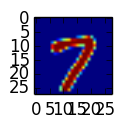

Prediction :7 Index:2473


In [69]:
# print out the data for the correct images
rand_idx = right_idx[convert(Int, ceil(rand() * length(right_idx)))]
x =reshape(trainX[rand_idx,:], 28,28)
figure(figsize=(1,1))
imshow(x)
println("Prediction :$(pred[rand_idx]) Index:$(rand_idx)")


In [95]:
# print out some incorrect images
for i in 1:10
rand_idx = wrong_idx[convert(Int, ceil(rand() * length(wrong_idx)))]
x =reshape(trainX[rand_idx,:], 28,28)
figure(figsize=(1,1))
#imshow(x)
    println("Prediction :$(pred[rand_idx]) Correct Value :$(trainY[rand_idx]) Index:$(rand_idx)")
end

Prediction :1 Correct Value :9.0 Index:1244
Prediction :2 Correct Value :0.0 Index:3200
Prediction :1 Correct Value :8.0 Index:1939
Prediction :1 Correct Value :5.0 Index:234
Prediction :2 Correct Value :0.0 Index:3540
Prediction :1 Correct Value :5.0 Index:4637
Prediction :2 Correct Value :0.0 Index:239
Prediction :1 Correct Value :9.0 Index:2958
Prediction :1 Correct Value :8.0 Index:3341
Prediction :10 Correct Value :2.0 Index:4827


In [96]:
N = size(trainX)[1]
super_wrong = filter(i -> abs(pred[i] -10)<1e-5, 1:N)
length(super_wrong)

79